In [1]:
from tensorflow.keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Flatten, Reshape, Input
import numpy as np


In [2]:
(X_train, _), (X_test, _) = mnist.load_data()
X_train = X_train.astype(np.float64)[:150] / 255.


In [3]:
compression_level = 32

In [4]:
input_im = Input(shape=(28,28,1))
layer0 = Reshape((28**2,))(input_im)
layer1 = Dense(4*28**2, activation='sigmoid')(layer0)
layer2 = Dense(compression_level, activation='relu')(layer1)

encoder = Model(input_im, layer2)

input_de = Input(shape=(compression_level,))
layer3 = Dense(4*28**2, activation='sigmoid', input_shape=(compression_level,))(input_de)
layer4 = Dense(28**2, activation='sigmoid')(layer3)
outlayer = Reshape((28,28,1))(layer4)

decoder = Model(input_de, outlayer)

2021-07-27 14:37:30.609771: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
autoencoder = Model(inputs=input_im, outputs=decoder(encoder(input_im)))

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [6]:

autoencoder.fit(X_train, X_train, 150, 200, shuffle=True)

2021-07-27 14:37:31.025382: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200
1/1 [==============================] - 19s 19s/step - loss: 0.7412
Epoch 2/200
1/1 [==============================] - 0s 75ms/step - loss: 0.3952
Epoch 3/200
1/1 [==============================] - 0s 81ms/step - loss: 0.2963
Epoch 4/200
1/1 [==============================] - 0s 89ms/step - loss: 0.2855
Epoch 5/200
1/1 [==============================] - 0s 85ms/step - loss: 0.2887
Epoch 6/200
1/1 [==============================] - 0s 131ms/step - loss: 0.2838
Epoch 7/200
1/1 [==============================] - 0s 222ms/step - loss: 0.2788
Epoch 8/200
1/1 [==============================] - 0s 163ms/step - loss: 0.2793
Epoch 9/200
1/1 [==============================] - 0s 106ms/step - loss: 0.2804
Epoch 10/200
1/1 [==============================] - 0s 87ms/step - loss: 0.2774
Epoch 11/200
1/1 [==============================] - 0s 91ms/step - loss: 0.2726
Epoch 12/200
1/1 [==============================] - 0s 87ms/step - loss: 0.2697
Epoch 13/200
1/1 [===========================

In [7]:
import matplotlib.pyplot as plt

In [8]:
a = X_test[:100]

a = autoencoder.predict(a)

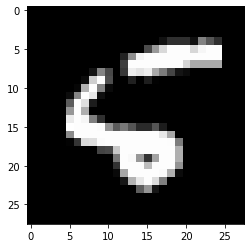

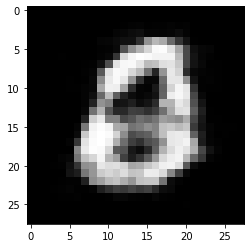

In [9]:
n=8

plt.imshow(X_test[n], cmap='gray')
plt.show()
plt.imshow(a[n], cmap='gray')
plt.show()

(100, 28, 28, 1)


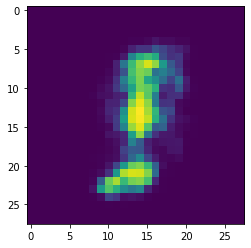

array([[ 0.      ,  0.      , 69.50743 ,  0.      , 19.24131 ,  0.      ,
         0.      , 11.612603,  0.      ,  0.      ,  0.      , 60.54023 ,
        53.382904,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
         0.      , 21.43809 ,  0.      ,  0.      ,  0.      ,  8.893706,
         0.      , 10.596368,  0.      , 42.83391 , 35.94171 , 72.08287 ,
        72.79234 ,  0.      ]], dtype=float32)

In [27]:
b = encoder.predict(a[:1])
print(a.shape)
b > 0
plt.imshow(decoder.predict(b>0)[0])
plt.show()
b

In [52]:
def compress(frame):
    import numpy as np
    # import matplotlib.pyplot as plt
    frame = frame.astype(np.float64)/255.
    block_size = 28
    size = frame.shape[0] // block_size, frame.shape[1] // block_size
    im_size = np.array([*size, 0])*block_size
    im_size[2] = 1
    res_img = np.zeros(im_size)
    blocks = np.zeros((size[0]*size[1], 28, 28, 1))
    for i in range(size[0]):
        for j in range(size[1]):
            blocks[i*size[1]+j] = frame[block_size*i:block_size*(i+1), block_size*j:block_size*(j+1), :1]   
    result = autoencoder.predict(blocks.reshape((size[0]*size[1], block_size, block_size, 1)))
    
    for i in range(size[0]):
        for j in range(size[1]):
            res_img[block_size*i:block_size*(i+1), block_size*j:block_size*(j+1)] = result[i*size[1]+j]
    # cv2.imshow('abc', res_img)
    return res_img     
    # red = np.array([[frame[i, j, 0] for j in range(frame.shape[1])] for i in range(frame.shape[0])])
    # channels = [np.array([[frame[i, j, k] for j in range(frame.shape[1])] for i in range(frame.shape[0])]) for k in range(frame.shape[2])]
    # cv2.imshow('123', channels[0])

In [53]:
import cv2
cap = cv2.VideoCapture(0)

In [54]:
while 1:
    ret, frame = cap.read()
    res = compress(frame)
    # break
    cv2.imshow('scr', res)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

work
work
work
work
work
work
work
work
work
work
work
work
work
work
work
work
work
work
work
work
work
work
work
work
work
work
work
work
work
work
work
work
work
work
work
work
work
work
work
work
work
work
work
work
work
work
work
work
work
work
work
work
work
work
work
work
work
work
work
work
work
work
work
work
work
work
work
work
work
work
work
work
work
work
work
work
work
work
work
work
work
work
work
work
work
work
work
work
work
work
work
work
work
work
work


KeyboardInterrupt: 